# Example Q4: Running a Basic Experiment
This example notebook shows how run Auspex qubit experiments using the fake data interface.

(c) Raytheon BBN Technologies 2018

First we ask auspex to run in dummy mode, which avoids loading instrument drivers.

In [1]:
import auspex.config as config
config.auspex_dummy_mode = True

In [ ]:
from QGL import *
from auspex.qubit import *

Channel library setup

In [4]:
cl = ChannelLibrary(db_resource_name=":memory:")
pl = PipelineManager()

q1 = cl.new_qubit("q1")
aps2_1 = cl.new_APS2("BBNAPSa", address="192.168.2.4", trigger_interval=200e-6) 
aps2_2 = cl.new_APS2("BBNAPSb", address="192.168.2.2")
dig_1  = cl.new_Alazar("Alazar_1", address="1", sampling_rate=500e6, record_length=1024)
h1 = cl.new_source("Holz_1", "HolzworthHS9000", "HS9004A-009-1", reference='10MHz', power=-30)
h2 = cl.new_source("Holz_2", "HolzworthHS9000", "HS9004A-009-2", reference='10MHz', power=-30)

cl.set_measure(q1, aps2_1, dig_1.ch("1"), trig_channel=aps2_1.ch("m2"), gate=False, generator=h1)
cl.set_control(q1, aps2_2, generator=h2)
cl.set_master(aps2_1, aps2_1.ch("m1"))
cl["q1"].measure_chan.frequency = 0e6
cl["q1"].measure_chan.autodyne_freq = 10e6

Pipeline setup

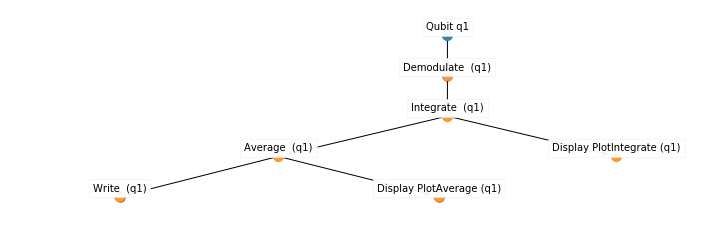

In [9]:
pl.create_default_pipeline()
pl["q1"].clear_pipeline()
pl["q1"].set_stream_type("raw")
pl["q1"].create_default_pipeline()

pl["q1"]["Demodulate"]["Integrate"]["Average"].add(Display(label="PlotAverage"), connector_out="partial_average")
pl["q1"]["Demodulate"]["Integrate"].add(Display(label="PlotIntegrate"))

pl.show_pipeline()

Initialize software demodulation parameters. If these are not properly configured than the `Channelizer` filter will report 'insufficient decimation' or other errors. The integration boxcar parameters are then defined.

In [10]:
demod = pl["q1"]["Demodulate"]
demod.frequency = cl["q1"].measure_chan.frequency
demod.decimation_factor = 16

In [11]:
integ = pl["q1"]["Demodulate"]["Integrate"]
integ.box_car_start = 0.2e-6
integ.box_car_stop= 1.9e-6

## Taking Fake Data

Now we create a simple experiment, but ask the digitizer to emit fake data of our choosing. This is useful for debugging one's configuration without having access to hardware. The `set_fake_data` method loads the fake dataset into the indicated digitizer's driver. The digitizer driver automatically chooses the nature of it's output depending on whether receiver channels are raw, demodulated, or integrated.

In [12]:
amps = np.linspace(-1,1,51)

exp = QubitExperiment(RabiAmp(q1,amps),averages=50)
exp.set_fake_data(dig_1, np.cos(np.linspace(0, 2*np.pi,51)))
exp.run_sweeps() 

Compiled 51 sequences.
auspex-INFO: 2019-02-27 14:31:06,866 ----> Connection established to plot server.


## Plotting and the Plot Server & Client
The `Display` nodes in the filter pipeline are turned into live plotters. In the `auspex/utils` directory once can find `auspex-plot-server.py` and `auspex-plot-client.py`. The server, which should be executed first, acts as a data router and can accept multiple clients (and even multiple concurrent Auspex runs). The client polls the server to see whether any plots are available. If so, it grabs their descriptions and constructs a tab for each `Display` filter. The plots are updated as new data becomes available, and will look something like this:

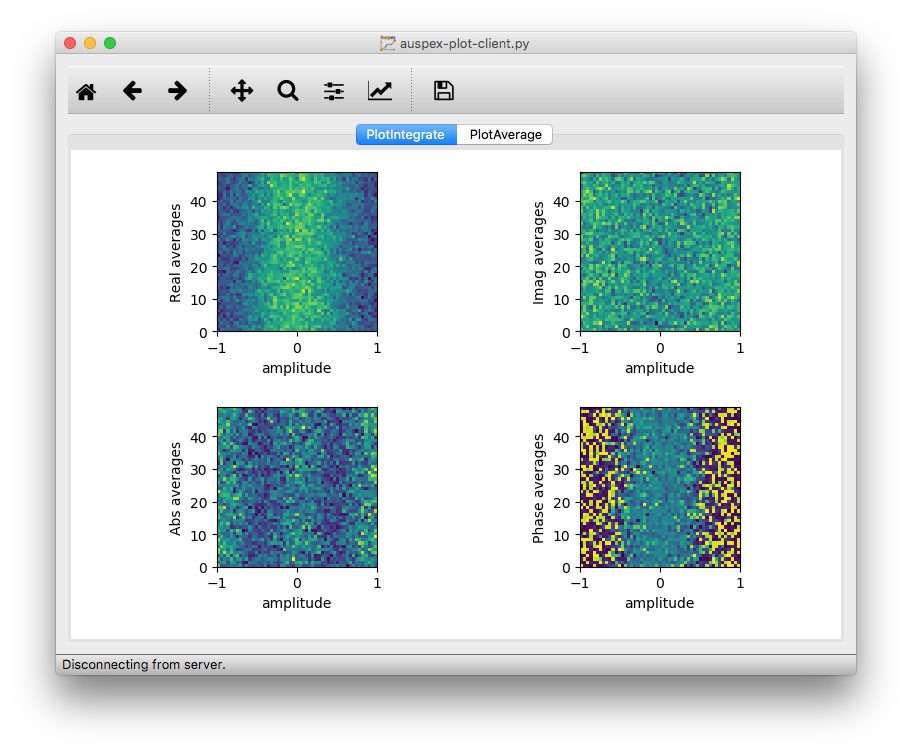

For every execution of `run_sweeps` on an experiment, a new plot will be opened. In the plot client menus, however, the user can close all previous plots as well as choose to 'Auto Close Plots', which closes any previous plots before opening another.

### Remote Usage
The plot server and client can be run remotely, as can the Jupyter notebooks one expects to run. By running the following ssh port-forwarding command:
```bash
ssh -R 7761:localhost:7761 -R 7762:localhost:7762 -L 8889:my.host.com:8888 -l username my.host.com
```
You could connect to a remotely running Jupyter notebook on port 8888 locally at port 8889, and then (after starting `auspex-plot-server.py` and `auspex-plot-client.py` on your local machine) watch new plots appear in a live window on your local machine.

This presumes one does not have unfettered network access to the remote host, in which case ssh tunneling is not necessary. Currently the plotter and client assume they are all connecting on localhost, but we will create a convenient interface for their configuration soon.

## Monitoring Changes in the Channel Library

The session keeps track of what values have changed without being committed, e.g.:

In [29]:
cl.session.commit()
cl.session.dirty

IdentitySet([])

Everything is in sync with the database. Now we modify some property:

In [34]:
aps2_1.ch(1).amp_factor = 0.95
cl.session.dirty

IdentitySet([PhysicalQuadratureChannel('BBNAPSa-1')])

We see that things have changed that haven't been committed to the database. This can be rectified with another `commit`, or optionally a `rollback`!

In [37]:
cl.session.rollback()
aps2_1.ch(1).amp_factor

1.0